# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=200)

[899624,
 1044078,
 871756,
 1106523,
 844179,
 883932,
 1046545,
 832678,
 8090539,
 5569230,
 965766,
 865456,
 8090537,
 823990,
 944534,
 1025535,
 925862,
 999779,
 1004906,
 8090521,
 999714,
 947858,
 5585510,
 1051323,
 835530,
 7441873,
 854852,
 1000753,
 5568378,
 9836106,
 1133312,
 9835223,
 993638,
 1003616,
 828106,
 835300,
 12262978,
 896862,
 863447,
 870547,
 830304,
 895166,
 1096573,
 1092937,
 1029743,
 823704,
 952163,
 986912,
 965267,
 1036347,
 963727,
 990797,
 1134678,
 12731517,
 850102,
 1001702,
 824180,
 913278,
 896613,
 15926886,
 1081177,
 832442,
 1100972,
 5569845,
 841220,
 902172,
 942525,
 831728,
 1038663,
 888543,
 865528,
 6534480,
 1102879,
 880150,
 1059902,
 9836195,
 12301839,
 1131344,
 1006878,
 1004390,
 837304,
 879504,
 999270,
 1037863,
 838186,
 1097458,
 12731432,
 1070702,
 937292,
 936355,
 850925,
 8065410,
 9526410,
 831517,
 12757140,
 1068719,
 1068292,
 1116376,
 940090,
 998556,
 827919,
 9553065,
 1026984,
 12302069,
 8520

In [6]:
recommender.get_own_recommendations(2375, N=200)

[948640,
 918046,
 847962,
 907099,
 873980,
 884694,
 10285454,
 1107760,
 7169090,
 979674,
 10308345,
 1069531,
 974766,
 1015474,
 950935,
 847066,
 1102207,
 1020770,
 9521787,
 974265,
 940996,
 8019845,
 5567194,
 12811490,
 1003616,
 973181,
 890719,
 982955,
 9677152,
 998519,
 1072685,
 1131382,
 1021715,
 12263119,
 960791,
 7441873,
 986021,
 956666,
 1038692,
 9677748,
 9297223,
 927030,
 12757653,
 1046919,
 6391532,
 989069,
 1068451,
 951954,
 835300,
 937343,
 1047249,
 13876348,
 1061732,
 981601,
 1121028,
 1087547,
 828393,
 996269,
 951951,
 1036093,
 1023815,
 5570408,
 827667,
 1082454,
 1006878,
 5570048,
 841309,
 1078652,
 1115553,
 1056492,
 1138467,
 1004945,
 947858,
 1092885,
 1121694,
 938138,
 8019916,
 827919,
 984315,
 10341855,
 883932,
 8291322,
 1096794,
 1028938,
 1087618,
 8020166,
 1082185,
 866871,
 930666,
 825994,
 910151,
 823990,
 848029,
 896613,
 12301839,
 1117219,
 1135258,
 869868,
 1046545,
 899624,
 6442594,
 1137775,
 825343,
 104290

In [7]:
recommender.get_similar_items_recommendation(2375, N=200)

[1046545,
 1044078,
 937292,
 945662,
 15778319,
 844462,
 1003616,
 896613,
 885863,
 1025535,
 1044078,
 878996,
 906923,
 871611,
 999714,
 919681,
 828106,
 1018740,
 1021522,
 896292,
 1070702,
 907099,
 9835606,
 12301100,
 899624,
 965041,
 1014116,
 965842,
 985999,
 1037417,
 9835903,
 1127025,
 1000753,
 9835960,
 1130517,
 954525,
 849205,
 1055503,
 825317,
 950200,
 1101175,
 916122,
 869322,
 12984576,
 12781777,
 12648296,
 947201,
 1079976,
 8065410,
 1056005,
 954651,
 960732,
 10285442,
 7441210,
 904574,
 1112238,
 865456,
 828106,
 883068,
 1105488,
 839818,
 825343,
 1120559,
 1038998,
 899459,
 12263119,
 8090537,
 882247,
 5568378,
 948650,
 1048272,
 1070702,
 1098435,
 960732,
 957411,
 969945,
 13115637,
 1008799,
 1133312,
 12301784,
 1042907,
 844179,
 1055503,
 5565202,
 9297055,
 897752,
 8019902,
 1139142,
 946484,
 844179,
 952521,
 12810389,
 1139216,
 1084613,
 1028953,
 856827,
 1072519,
 937292,
 1018740,
 1087755,
 994995,
 1087102,
 7024871,
 93324

In [8]:
recommender.get_similar_users_recommendation(2375, N=200)

[1012801,
 10457044,
 974265,
 963686,
 1096573,
 1101502,
 892728,
 894360,
 1038745,
 12523928,
 9245108,
 820612,
 965956,
 12427353,
 1118120,
 945909,
 918638,
 920025,
 1107760,
 873715,
 948640,
 1131625,
 950894,
 896757,
 925863,
 949257,
 1124971,
 874563,
 902640,
 12523928,
 7410021,
 994577,
 1108168,
 1010308,
 995502,
 939681,
 1026945,
 875392,
 935578,
 921406,
 9297574,
 1121808,
 832661,
 1117602,
 12352054,
 5707857,
 977927,
 1081533,
 1055403,
 837495,
 10198378,
 871514,
 7409622,
 951834,
 969866,
 5568758,
 12262832,
 8020166,
 1021715,
 9553382,
 1060292,
 1068865,
 847434,
 947412,
 1123045,
 948239,
 902640,
 5569309,
 873324,
 1065259,
 1037135,
 1116050,
 1129805,
 830686,
 959830,
 822970,
 6979437,
 917033,
 1139782,
 1118946,
 873324,
 857130,
 6391089,
 983665,
 10198378,
 10341855,
 1074040,
 1102003,
 5568758,
 997423,
 882826,
 1057168,
 1057168,
 948225,
 910151,
 1112405,
 916990,
 5574377,
 1115069,
 1036486,
 873044,
 1057168,
 1123106,
 6391557

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 200 кандидатов (k=200)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [16]:
data_val_lvl_1

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282320,222,41297772783,635,1120741,1,0.59,304,0.00,1716,91,0.0,0.0
2282321,462,41297773713,635,993339,1,1.99,304,0.00,2040,91,0.0,0.0
2282322,462,41297773713,635,995242,1,1.00,304,-0.89,2040,91,0.0,0.0
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0


In [115]:
# A)  Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
k=200
current_user_id=2375

bought_list=data_val_lvl_1[data_val_lvl_1['user_id']==current_user_id]['item_id'].unique().tolist()

recommended_list=recommender.get_als_recommendations(current_user_id, N=k)
recall_result = recall_at_k(recommended_list,bought_list,k=k)
print('get_als_recommendations',recall_result)

recommended_list=recommender.get_own_recommendations(current_user_id, N=k)
recall_result = recall_at_k(recommended_list,bought_list,k=k)
print('get_own_recommendations',recall_result)

recommended_list=recommender.get_similar_items_recommendation(current_user_id, N=k)
recall_result = recall_at_k(recommended_list,bought_list,k=k)
print('get_similar_items_recommendation',recall_result)

recommended_list=recommender.get_similar_users_recommendation(current_user_id, N=k)
recall_result = recall_at_k(recommended_list,bought_list,k=k)
print('get_similar_users_recommendation',recall_result)

get_als_recommendations 0.14705882352941177
get_own_recommendations 0.17647058823529413
get_similar_items_recommendation 0.08823529411764706
get_similar_users_recommendation 0.0


Дают ли own recommendtions + top-popular лучший recall?

Да, дают - get_own_recommendations имеет наибольшее значение

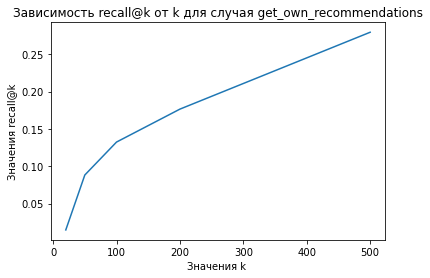

In [116]:
# B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
def get_recall_at_k(k_arr, user_id, bought_list, recall_at_k_func, get_recommendations_func):
    result=[recall_at_k_func(get_recommendations_func(user_id,N=k),bought_list,k=k) for k in k_arr]
    return result

k_arr=[20, 50, 100, 200, 500]
user_id=2375
result=get_recall_at_k(k_arr, user_id, bought_list, recall_at_k, recommender.get_own_recommendations)
    
import matplotlib.pyplot as plt


plt.plot(k_arr,result)
plt.title("Зависимость recall@k от k для случая get_own_recommendations")
plt.xlabel('Значения k ')
plt.ylabel('Значения recall@k')
plt.show()   



C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

Скорее всего то что дает наибольшее значение, т е у нас это k=500

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

Будем использовать характеристики для юзера и товара, которые пришли из user_features и из item_features
В курсовом проекте сделаю доболнительные характеристики для юзера, товара, а также для пары юзер-товар 

In [66]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=200))

In [67]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная пересенная



In [68]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [69]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [70]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [71]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

C:\Users\Windows\Anaconda3\envs\python38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Windows\Anaconda3\envs\python38\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Wall time: 1.86 s


In [99]:
pd_train_preds=pd.DataFrame(train_preds)
pd_train_preds.columns=['target']
pd_train_preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [80]:
X_train

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437597,1745,849202,239,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
437598,1745,944137,2274,PRODUCE,National,PEPPERS-ALL,PEPPERS OTHER BELL,3 CT,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
437599,1745,1051211,1266,GROCERY,National,PNT BTR/JELLY/JAMS,PEANUT BUTTER,18 OZ,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown
437600,1745,831628,2949,MEAT,National,BEEF,CHOICE BEEF,,45-54,A,Under 15K,Unknown,Single Male,2,None/Unknown


In [102]:
X_train_with_predicts=pd_train_preds.merge(X_train, left_index=True, right_index=True)
X_train_with_predicts.head(2)

,target,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,0.0,2070,1105426,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,0.0,2070,1097350,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [103]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [144]:
X_train_with_predicts[X_train_with_predicts['target']==1.0].groupby([ 'user_id','target'])['item_id'].unique()

user_id  target
1        1.0                                      [9655212, 8293439]
13       1.0                                                [880050]
16       1.0                                               [1082185]
19       1.0                                                [962229]
20       1.0       [1075368, 1126899, 1098248, 1029743, 1106523, ...
                                         ...                        
2446     1.0                                      [1044259, 1085435]
2449     1.0                                               [1071446]
2479     1.0                             [845975, 1061982, 15926886]
2483     1.0                                               [1082185]
2497     1.0                                       [900802, 1082185]
Name: item_id, Length: 378, dtype: object

In [166]:
k=5
current_user_id=2479
bought_list_2=targets_lvl_2[(targets_lvl_2['user_id']==current_user_id) & \
                             (targets_lvl_2['target']==1.0)]['item_id'].unique().tolist()
bought_list_2

[979877,
 859987,
 8090560,
 1039672,
 920654,
 972657,
 845975,
 896757,
 1098435,
 893676,
 947146,
 1061982,
 1134810,
 1070272,
 8090541,
 870421,
 1056973,
 9527187,
 867447,
 825659,
 909714,
 15926886,
 9835509,
 5565925,
 843891,
 8090539]

In [167]:
recommended_list_2=X_train_with_predicts[(X_train_with_predicts['user_id']==current_user_id) & \
                                       (X_train_with_predicts['target']==1.0)]['item_id'].unique().tolist()

recommended_list_2

[845975, 1061982, 15926886]

In [168]:
print('Уровень 2 ',precision_at_k(recommended_list_2,bought_list_2,k=5))

Уровень 2  1.0


In [169]:
recommended_list_1=recommender.get_own_recommendations(current_user_id, N=5)


In [170]:
bought_list_1=data_val_lvl_1[data_val_lvl_1['user_id']==current_user_id]['item_id'].unique().tolist()


In [171]:
print('Уровень 1 ',precision_at_k(recommended_list_1,bought_list_1,k=5))

Уровень 1  0.4


Вывод: для конкретного пользователя 2 уровень двухуровневой модели дает лучшие предсказания и лучшую точность чем 1 уровень (или одноуровневая модель)

### Финальный проект

Мы уже прошли всю необходимую теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов**
- **Все товары из разных категорий** (категория - department)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)